# All import's

In [0]:
! pip install pyfpgrowth

In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import seaborn as sns
import numpy as np
import  matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds

import pyfpgrowth
from umap import UMAP
from sklearn.manifold import TSNE
import gc

In [0]:
sns.set_style('darkgrid')

# Install pyfim

In [0]:
!wget http://www.borgelt.net/src/pyfim.zip

--2019-11-18 14:14:11--  http://www.borgelt.net/src/pyfim.zip
Resolving www.borgelt.net (www.borgelt.net)... 134.0.30.202, 2a03:2900:7::13
Connecting to www.borgelt.net (www.borgelt.net)|134.0.30.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 881543 (861K) [application/zip]
Saving to: ‘pyfim.zip’

pyfim.zip           100%[===================>] 860.88K   134KB/s    in 13s     

2019-11-18 14:14:25 (68.4 KB/s) - ‘pyfim.zip’ saved [881543/881543]



In [0]:
!unzip -q pyfim.zip

In [0]:
!python setup_fim.py install

running install
running build
running build_ext
building 'fim' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/util
creating build/temp.linux-x86_64-3.6/util/src
creating build/temp.linux-x86_64-3.6/math
creating build/temp.linux-x86_64-3.6/math/src
creating build/temp.linux-x86_64-3.6/tract
creating build/temp.linux-x86_64-3.6/tract/src
creating build/temp.linux-x86_64-3.6/apriori
creating build/temp.linux-x86_64-3.6/apriori/src
creating build/temp.linux-x86_64-3.6/eclat
creating build/temp.linux-x86_64-3.6/eclat/src
creating build/temp.linux-x86_64-3.6/fpgrowth
creating build/temp.linux-x86_64-3.6/fpgrowth/src
creating build/temp.linux-x86_64-3.6/sam
creating build/temp.linux-x86_64-3.6/sam/src
creating build/temp.linux-x86_64-3.6/relim
creating build/temp.linux-x86_64-3.6/relim/src
creating build/temp.linux-x86_64-3.6/carpenter
creating build/temp.linux-x86_64-3.6/carpenter/src
creating build/temp.linux-x86_64-3.6/ista
creating buil

In [0]:
from fim import fpgrowth

# Load data

In [0]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1EMS377_Ew2h0esEMdEj54X894J_xU7Fl', dest_path='./data/instacart_online_grocery_shopping_2017_05_01.tar.gz')


In [0]:
! mkdir ./data/unziped

In [0]:
! tar -xzf ./data/instacart_online_grocery_shopping_2017_05_01.tar.gz -C ./data/unziped

# EDA

Table with info about order

In [0]:
orders_df = pd.read_csv('./data/unziped/instacart_2017_05_01/orders.csv')

We have orders, but no items here.

In [0]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


We have nans only in days_since_prior_order column.

In [0]:
orders_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  3421083 non-null int64
user_id                   3421083 non-null int64
eval_set                  3421083 non-null object
order_number              3421083 non-null int64
order_dow                 3421083 non-null int64
order_hour_of_day         3421083 non-null int64
days_since_prior_order    3214874 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


Investigate eval_set

In [0]:
orders_df['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

At first drop eval_set = test, because we have no private data

In [0]:
orders_df = orders_df.drop(orders_df[orders_df['eval_set'] == 'test'].index)

In [0]:
orders_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  3346083 non-null int64
user_id                   3346083 non-null int64
eval_set                  3346083 non-null object
order_number              3346083 non-null int64
order_dow                 3346083 non-null int64
order_hour_of_day         3346083 non-null int64
days_since_prior_order    3139874 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 204.2+ MB


No duplicates in order_id

In [0]:
orders_df.nunique()

order_id                  3346083
user_id                    206209
eval_set                        2
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [0]:
orders_df['order_dow'].unique()

array([2, 3, 4, 1, 5, 0, 6])

In [0]:
orders_df['order_hour_of_day'].unique()

array([ 8,  7, 12, 15,  9, 14, 16, 11, 10, 19, 18, 17, 13, 20,  0, 21, 22,
        5, 23,  4,  6,  1,  2,  3])

In [0]:
orders_df['days_since_prior_order'].unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11.,  4.,  5.,  2., 23., 26.,
       25., 16.,  1., 18., 24., 22.])

1. All order_id are unique
2. We have 206209 unique users
3. order_dow, order_hour_of_day, days_since_prior_order correspond their description

Fill na in days_since_prior_order as 999

In [0]:
orders_df.fillna(999, inplace=True)

When people make orders?

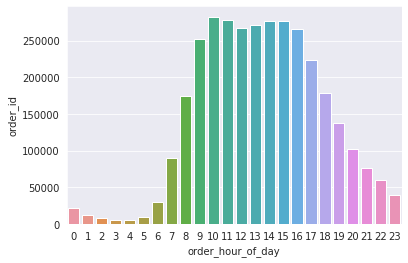

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('order_hour_of_day').agg({'order_id':'count'}).reset_index(), x='order_hour_of_day', y='order_id',ax=ax)

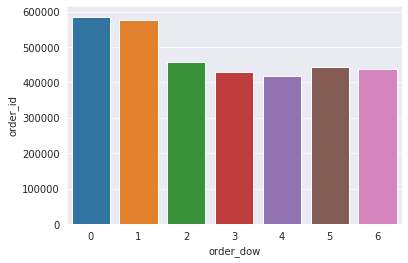

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('order_dow').agg({'order_id':'count'}).reset_index(), x='order_dow', y='order_id',ax=ax)

When people reorder

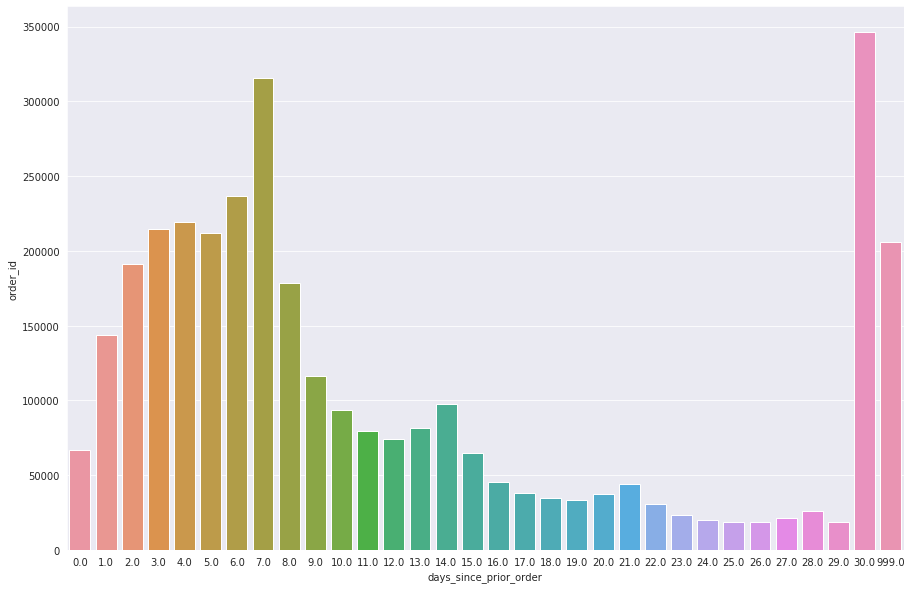

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(data=orders_df.groupby('days_since_prior_order').agg({'order_id':'count'}).reset_index(), x='days_since_prior_order', y='order_id',ax=ax)

Distribution of orders number within users

Interesting outlier

Text(0.5, 0, 'orders per user')

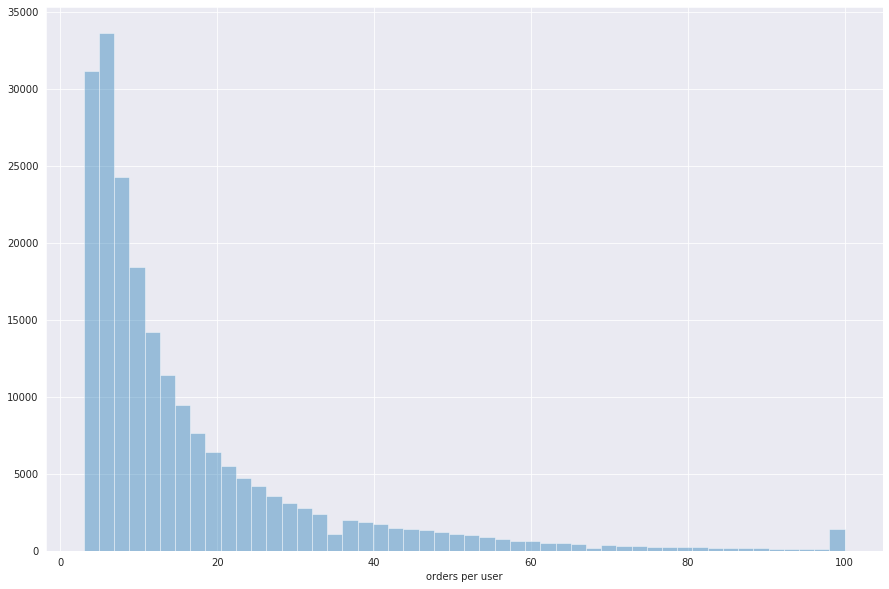

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(orders_df['user_id'].value_counts(),kde=False,ax=ax)
ax.set_xlabel('orders per user')

Table with prior orders

In [0]:
order_products_prior_df = pd.read_csv('./data/unziped/instacart_2017_05_01/order_products__prior.csv')

In [0]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


No nulls

In [0]:
order_products_prior_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             32434489 non-null int64
product_id           32434489 non-null int64
add_to_cart_order    32434489 non-null int64
reordered            32434489 non-null int64
dtypes: int64(4)
memory usage: 989.8 MB


In [0]:
order_products_prior_df.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

No duplicates

In [0]:
order_products_prior_df.duplicated().any()

False

Table with train orders

In [0]:
order_products_train_df = pd.read_csv('./data/unziped/instacart_2017_05_01/order_products__train.csv')

In [0]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


No nulls

In [0]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [0]:
order_products_train_df.nunique()

order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64

No duplicates

In [0]:
order_products_train_df.duplicated().any()

False

We have no test orders table

Just load products, investigation later

In [0]:
products_df = pd.read_csv('./data/unziped/instacart_2017_05_01/products.csv')

Check mapping order_products_train/prior, orders and products

In [0]:
set(order_products_train_df['product_id'].unique()).issubset(set(products_df['product_id'].unique()))

True

In [0]:
set(order_products_prior_df['product_id'].unique()).issubset(set(products_df['product_id'].unique()))

True

In [0]:
set(orders_df.loc[orders_df['eval_set']=='train',:]['order_id'].unique()) == set(order_products_train_df['order_id'].unique())

True

In [0]:
set(orders_df.loc[orders_df['eval_set']=='prior',:]['order_id'].unique()) == set(order_products_prior_df['order_id'].unique())

True

So, no problem with mapping

Concatenate order_products_train/prior 

In [0]:
concated_df = pd.concat([order_products_prior_df, order_products_train_df])

Distribution of items number per order in prior

Text(0.5, 0, 'number of items in order')

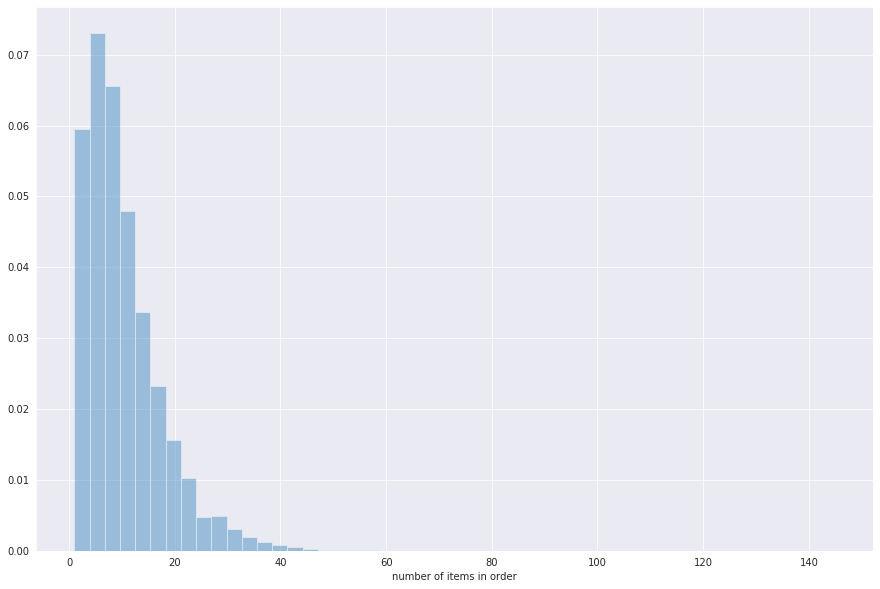

In [0]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.distplot(concated_df['order_id'].value_counts(),kde=False,ax=ax, norm_hist=True)
ax.set_xlabel('number of items in order')

Check most popular items 

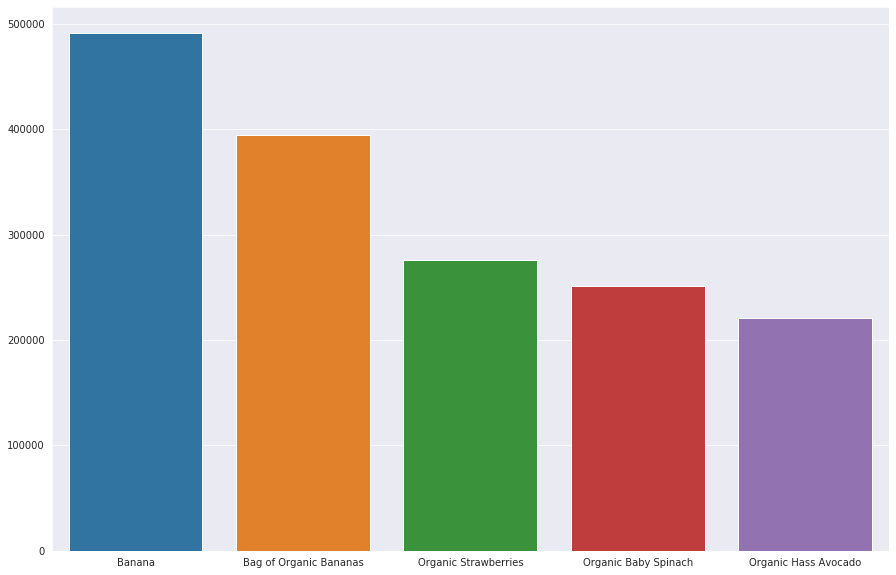

In [0]:
merged = concated_df.merge(products_df,on='product_id',how='left')['product_name'].value_counts()[:5]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)

Table with info about products

In [0]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


No nulls

In [0]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


No duplicates into product_id and product_name

In [0]:
products_df.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

Try to find dummy

In [0]:
concated_df.merge(products_df,on='product_id',how='left').groupby('product_name').agg({'order_id':'count'}).sort_values(by='order_id', ascending=False)[:20]

,order_id
product_name,
Banana,491291
Bag of Organic Bananas,394930
Organic Strawberries,275577
Organic Baby Spinach,251705
Organic Hass Avocado,220877
Organic Avocado,184224
Large Lemon,160792
Strawberries,149445
Limes,146660


In [0]:
products_df['product_name'].str.contains('coupon').any()

False

In [0]:
products_df['product_name'].str.contains('points').any()

False

In [0]:
products_df['product_name'].str.contains('dummy').any()

False

It seems that there are no dummy

Table with info about aisles

In [0]:
aisles_df = pd.read_csv('./data/unziped/instacart_2017_05_01/aisles.csv')

In [0]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


No nulls

In [0]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


No duplicates

In [0]:
aisles_df.nunique()

aisle_id    134
aisle       134
dtype: int64

Table with info about departments

In [0]:
departments_df = pd.read_csv('./data/unziped/instacart_2017_05_01/departments.csv')

In [0]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


No nulls

In [0]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


No duplicates

In [0]:
departments_df.nunique()

department_id    21
department       21
dtype: int64

Check mapping between aisles, products and departments

In [0]:
set(aisles_df['aisle_id'].unique()) == set(products_df['aisle_id'].unique())

True

In [0]:
set(departments_df['department_id'].unique()) == set(products_df['department_id'].unique())

True

How often people reorder items?

Text(0.5, 0, 'reordered')

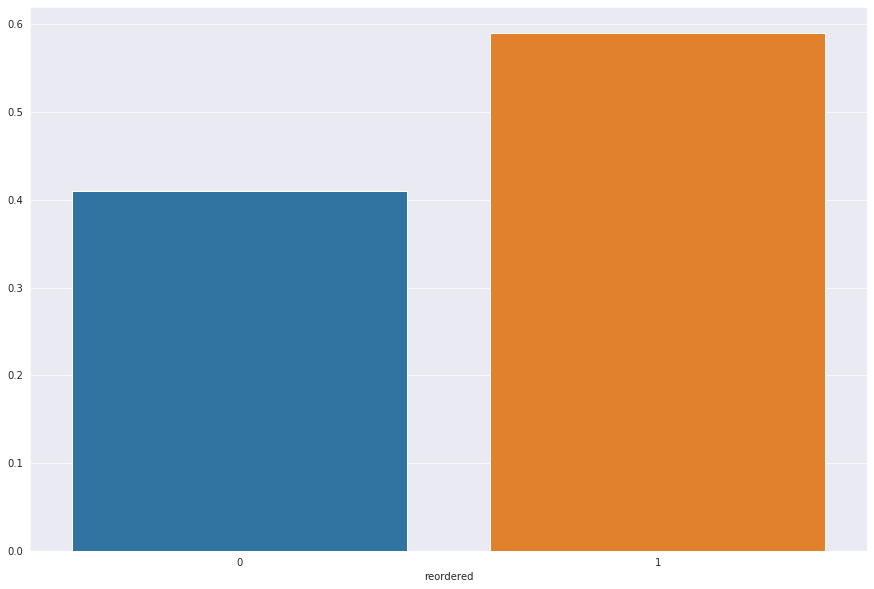

In [0]:
merged = concated_df['reordered'].value_counts(normalize=True)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)
ax.set_xlabel('reordered')

Which products are first in order?

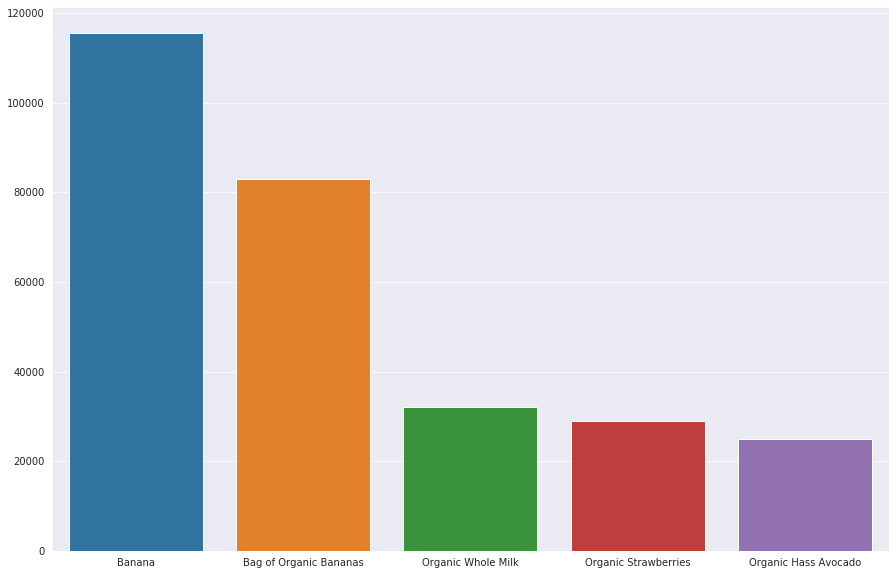

In [0]:
merged = concated_df.query('add_to_cart_order == 1').merge(products_df,on='product_id',how='left')['product_name'].value_counts()[:5]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
sns.barplot(x=merged.index, y=merged.values,ax=ax)

We can see that most popular products are first in order

Distribution of products by aisles

In [0]:
aisles_df['aisle'].nunique()

134

In [0]:
merged_df = pd.merge(concated_df, products_df, on='product_id')

In [0]:
calc_prod_num_by_aisle = merged_df.groupby('aisle_id').agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'num_of_products'}).merge(aisles_df, on='aisle_id')

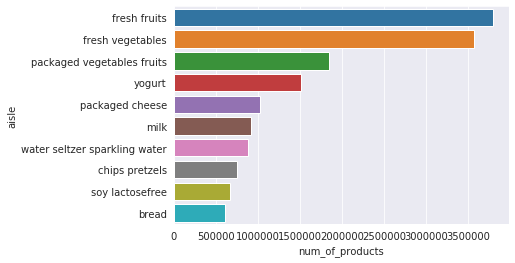

In [0]:
sns.barplot(data=calc_prod_num_by_aisle.sort_values(by='num_of_products', ascending=False).iloc[:10],x='num_of_products', y='aisle')

Most frequent are fruits and vegetables

Check whether all products are unique in one order

In [0]:
tmp_df = concated_df.groupby('order_id').agg(
    product_num=pd.NamedAgg(column='product_id', aggfunc='count'),
    product_nunique = pd.NamedAgg(column='product_id', aggfunc='nunique'))
sum(tmp_df['product_num'] != tmp_df['product_nunique'])

0

So all products in one order are unique

We have 1 order per user in train

In [0]:
orders_df[orders_df['eval_set'] == 'train'].groupby('user_id').agg({'order_id' : 'nunique'}).max()

order_id    1
dtype: int64

Distribution of orders per user in prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4697d27eb8>]],
      dtype=object)

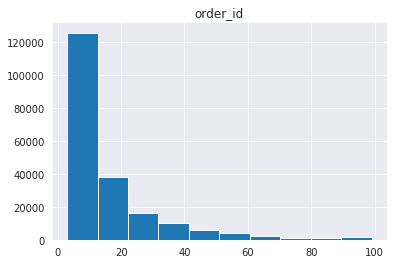

In [0]:
orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg({'order_id' : 'nunique'}).hist()

3 orders per user in prior minimum

In [0]:
orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg({'order_id' : 'nunique'}).min()

order_id    3
dtype: int64

# Metrics

In [0]:
def precision_at_k(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / k

In [0]:
def average_precision_at_k(predicted, actual, k):
  tmp = 0
  actual_length = min(k,len(actual))
  if len(predicted) < actual_length:
    warnings.warn("Length of predict is less than k")
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def mean_average_precision_at_k(predicted_list, actual_list, k):
  tmp = 0
  cnt = 0
  for predicted, actual in zip(predicted_list, actual_list):
    if len(actual) != 0:
      tmp += average_precision_at_k(predicted, actual, k)
      cnt += 1
  assert cnt != 0
  return tmp / cnt

# Basic Recommenders

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

In [0]:
class MostPopularRecommender():
  def __init__(self):
    pass
  
  def fit(self, X_train):
    assert type(X_train) == pd.DataFrame
    self.most_popular = list(X_train['product_id'].value_counts().index[:])
  
  def predict(self, X_test, top_n):
    predicted = pd.DataFrame()
    predicted['user_id'] = list(X_test['user_id'].unique())
    predicted['product_id'] = [self.most_popular[:top_n] for i in range(X_test['user_id'].nunique())]
    return predicted

Solve problem with svd later

In [0]:
#svd_input = prior_orders_merged_df.groupby(['user_id','product_id']).agg(buy_num=pd.NamedAgg(column='order_id', aggfunc='count')).reset_index()

In [0]:
#svds = SVDRecommender(10)
#svds.fit(svd_input)


In [0]:
class SVDRecommender():
  def __init__(self, k):
    self.k = k

  
  def fit(self, X_train):
    self.X_train = X_train
    R_df = X_train.pivot(index = 'user_id', columns ='product_id', values = 'buy_num')

    for index, row in R_df.iterrows():
      row.fillna(row.mean(),inplace=True)
      
    R = R_df.as_matrix()
    user_ratings_mean = np.mean(R, axis = 1)
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    
    
    U, sigma, Vt = svds(R_demeaned, self.k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    self.preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
    self.preds_df.index = R_df.index
    
  def predict(self, X_test, top_n):
    predicted_all_users_list = []
    for user in X_test['user_id'].unique():
      if user in self.X_train['user_id'].unique():
        predicted_all_users_list.append(list(self.preds_df.loc[user].sort_values(ascending=False).index[:top_n]))
    return predicted_all_users_list 

# FPGrow Recommender

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

In [0]:
def collect_products(x):
  return list(x.values)

In [0]:
transactions_df = prior_orders_merged_df.groupby('order_id').agg({'product_id' : collect_products}).reset_index()\
.rename(columns={'product_id':'transaction'})

In [0]:
transactions_list = list(transactions_df['transaction'].values)

In [0]:
len(transactions_list)

3214874

## pyfpgrowth

In [0]:
%%time
patterns = pyfpgrowth.find_frequent_patterns(transactions_list, int(0.03*len(transactions_list)))

CPU times: user 27.8 s, sys: 53.9 ms, total: 27.9 s
Wall time: 27.9 s


In [0]:
patterns

{(13176,): 379450,
 (16797,): 142951,
 (21137,): 264683,
 (21903,): 241921,
 (22935,): 113426,
 (24852,): 472565,
 (24964,): 109778,
 (26209,): 140627,
 (27845,): 137905,
 (27966,): 137057,
 (39275,): 100060,
 (45007,): 104823,
 (47209,): 213584,
 (47626,): 152657,
 (47766,): 176815,
 (49683,): 97315}

Absolutely impossible to use pyfpgrowth. Here support is 321487 and it more than hour, but we need support approximately 1000. Time grows exponentially.

## pyfim

In [0]:
freq_itemsets = list(fpgrowth(transactions_list, supp=-3000, zmin=3))

In [0]:
len(freq_itemsets)

278

In [0]:
freq_itemsets[0]

((21903, 21137, 24852), 9452)

In [0]:
freq_itemsets = sorted(freq_itemsets, key=lambda x: x[1],reverse=True)

In [0]:
prior_orders_merged_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,999.0,196,1,0
1,2539329,1,prior,1,2,8,999.0,14084,2,0
2,2539329,1,prior,1,2,8,999.0,12427,3,0
3,2539329,1,prior,1,2,8,999.0,26088,4,0
4,2539329,1,prior,1,2,8,999.0,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


Train most popular - it will help us if association rules recommendations not enough

In [0]:
mp = MostPopularRecommender()
mp.fit(prior_orders_merged_df)

Build recommendation for 1 user: iterate through all products in cart and all frequent itemsets. If not enough recommendations -> add from most popular, if too much recommendations -> remove things that customer has never bought before.

In [0]:
def build_rec_for_user(products, itemsets, prior_user_products, top_n=5):
  recommendation = set()
  for product in products:
    for itemset in itemsets:
      if product in itemset[0]:
        recommendation.update(itemset[0])
  # remove products which are in this order already
  recommendation = list(recommendation.difference(set(products)))
  # truncate recommendation
  trunc_recommendation = []
  if len(recommendation) > top_n:
    for rec in recommendation:
      if rec in prior_user_products:
        trunc_recommendation.append(rec)
        if len(trunc_recommendation) == top_n:
          break
  recommendation = trunc_recommendation
  if len(recommendation) < top_n:
    recommendation.extend(mp.most_popular[:top_n-len(recommendation)])
  

  return recommendation

In [0]:
def eval_results(actual, predicted,k):

  def collect(x):
    return list(x)
  
  ground_truth = actual.groupby('user_id').agg({'product_id':collect}).reset_index()
  return mean_average_precision_at_k(list(predicted['product_id']), list(ground_truth['product_id']), k)

Calc number of products in order

In [0]:
def calc_prod_in_cart(df):
  return df.groupby('order_id').agg(num_of_prods_in_cart=pd.NamedAgg(column='add_to_cart_order', aggfunc='max')).reset_index()['num_of_prods_in_cart']

In [0]:
number_of_products_in_cart = train_orders_merged_df.groupby('order_id').agg(num_of_prods_in_cart=pd.NamedAgg(column='add_to_cart_order', aggfunc='max')).reset_index()

We make prediction only on orders with number of products > 10

In [0]:
full_df = pd.merge(train_orders_merged_df, number_of_products_in_cart.query('num_of_prods_in_cart > 10'), on='order_id')

First 5 products in train, all that remains to test

In [0]:
train_df, test_df = full_df.query('add_to_cart_order <= 5'), full_df.query('add_to_cart_order > 5')

In [0]:
train_df.shape, test_df.shape

((264240, 11), (690968, 11))

In [0]:
grouped_by_user_test = test_df.groupby('user_id').agg({'product_id':lambda x: list(x)})
grouped_by_user_train = train_df.groupby('user_id').agg({'product_id':lambda x: list(x)})
grouped_by_user_prior = prior_orders_merged_df.groupby('user_id').agg({'product_id':lambda x: list(x)})

In [0]:
grouped_by_user_test

,product_id
user_id,
1,"[10258, 13032, 26088, 27845, 49235, 46149]"
2,"[22825, 13640, 24852, 45066, 9387, 5450, 24838..."
8,"[4853, 27104, 7058, 41259, 37803, 48230, 47766..."
9,"[12075, 8467, 38988, 30252, 18926, 24954, 4057..."
14,"[37434, 3808, 15172, 8744, 29509, 42284]"
...,...
206198,"[39021, 21709, 47107, 10411, 44142, 14897, 159..."
206199,"[38341, 43821, 38930, 12127, 49198, 22242, 770..."
206200,"[27451, 15592, 47209, 22312, 23484, 8955, 4697..."


In [0]:
predicted = pd.DataFrame(columns=('user_id', 'product_id'))
predicted['user_id'] = list(test_df['user_id'].unique())
predicted['product_id'] = [build_rec_for_user(grouped_by_user_train.loc[user,'product_id'], freq_itemsets, grouped_by_user_prior.loc[user, 'product_id'],3)\
 for user in predicted['user_id'].unique()]

In [0]:
predicted

,user_id,product_id
0,1,"[24852, 13176, 21137]"
1,2,"[24852, 13176, 21137]"
2,8,"[24852, 13176, 21137]"
3,9,"[24852, 13176, 21137]"
4,14,"[24852, 13176, 21137]"
...,...,...
52843,206198,"[24852, 13176, 21137]"
52844,206199,"[24852, 13176, 21137]"
52845,206200,"[47626, 37646, 21903]"
52846,206203,"[24852, 13176, 21137]"


In [0]:
eval_results(test_df, predicted, 3)

0.09579464796313851

# Switcher

## Mining features for users

In [0]:
train_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'train'], order_products_train_df, on='order_id')

Mining only in prior

In [0]:
prior_orders_merged_df = pd.merge(orders_df[orders_df['eval_set'] == 'prior'], order_products_prior_df, on='order_id')

In [0]:
prior_orders_merged_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,999.0,196,1,0
1,2539329,1,prior,1,2,8,999.0,14084,2,0
2,2539329,1,prior,1,2,8,999.0,12427,3,0
3,2539329,1,prior,1,2,8,999.0,26088,4,0
4,2539329,1,prior,1,2,8,999.0,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [0]:
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,999.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [0]:
def mode(x):
  return x.value_counts().index[0]

In [0]:
user_features1_df = orders_df[orders_df['eval_set'] == 'prior'].groupby('user_id').agg({'days_since_prior_order':'median', 'order_dow':mode,\
                                                                                       'order_hour_of_day':'median', 'order_number':'max'})

In [0]:
user_features1_df.rename(columns={'days_since_prior_order':'median_day_since_prior_order', 
                                  'order_dow':'mode_day',
                                  'order_hour_of_day':'median_hour_of_day',
                                  'order_number' : 'number_of_orders'}, inplace=True)

In [0]:
user_features1_df

,median_day_since_prior_order,mode_day,median_hour_of_day,number_of_orders
user_id,,,,
1,20.5,4,8.5,10
2,13.0,2,10.0,14
3,11.5,0,16.0,12
4,19.0,5,13.0,5
5,15.0,3,17.0,4
...,...,...,...,...
206205,30.0,2,15.0,3
206206,3.0,0,17.0,67
206207,12.0,2,12.0,16


In [0]:
def is_reordered(x):
  if 1 in list(x.values):
    return 1
  else:
    return 0

In [0]:
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [0]:
aggregated_by_orders = pd.merge(order_products_prior_df.groupby('order_id').agg({'product_id':'count', 'reordered':is_reordered}).reset_index().rename(columns={'product_id':'products_num'})\
         , orders_df[orders_df['eval_set'] == 'prior'], on='order_id')

In [0]:
user_features2_df = aggregated_by_orders.groupby('user_id').agg({'products_num' : 'median', 'reordered':is_reordered})

In [0]:
user_features2_df.rename(columns={'products_num':'median_number_of_products_in_order'}, inplace=True)

In [0]:
user_features2_df

,median_number_of_products_in_order,reordered
user_id,,
1,5.5,1
2,13.5,1
3,7.0,1
4,3.0,1
5,10.0,1
...,...,...
206205,8.0,1
206206,4.0,1
206207,13.0,1


In [0]:
user_features3_df = prior_orders_merged_df.groupby('user_id').agg(unique_prod_total=pd.NamedAgg(column = 'product_id', aggfunc='nunique'))

In [0]:
user_features3_df

,unique_prod_total
user_id,
1,18
2,102
3,33
4,17
5,23
...,...
206205,24
206206,150
206207,92


In [0]:
all_user_features_df = pd.concat([user_features1_df, user_features2_df, user_features3_df], axis=1)

In [0]:
all_user_features_df

,median_day_since_prior_order,mode_day,median_hour_of_day,number_of_orders,median_number_of_products_in_order,reordered,unique_prod_total
user_id,,,,,,,
1,20.5,4,8.5,10,5.5,1,18
2,13.0,2,10.0,14,13.5,1,102
3,11.5,0,16.0,12,7.0,1,33
4,19.0,5,13.0,5,3.0,1,17
5,15.0,3,17.0,4,10.0,1,23
...,...,...,...,...,...,...,...
206205,30.0,2,15.0,3,8.0,1,24
206206,3.0,0,17.0,67,4.0,1,150
206207,12.0,2,12.0,16,13.0,1,92


## Clustering users

In [0]:
inertias = []
for n_clusters in range(2,13):
  kmeans = KMeans(n_clusters=n_clusters, random_state=30).fit(all_user_features_df)
  print(n_clusters)
  inertias.append(kmeans.inertia_)

2
3
4
5
6
7
8
9
10
11
12


Text(0, 0.5, 'Sum of squared distances')

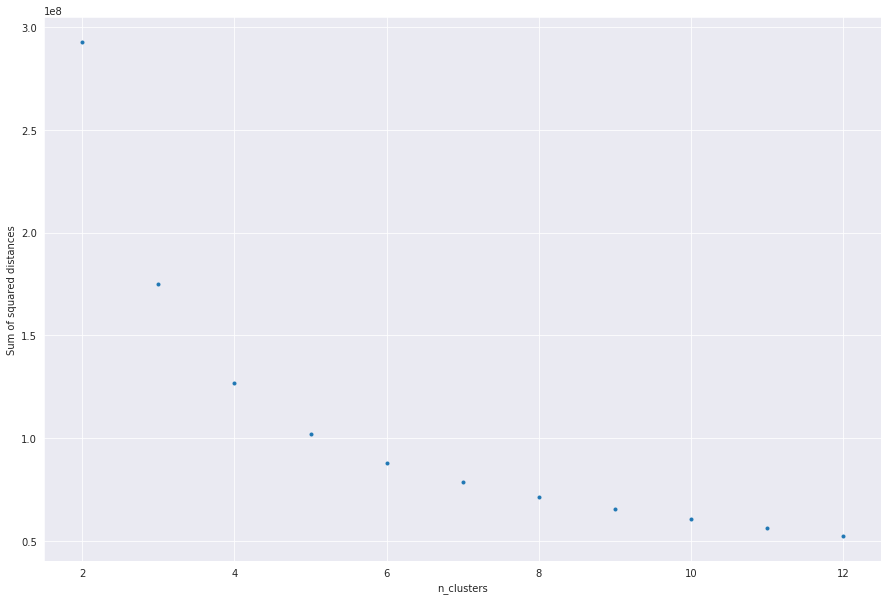

In [0]:
n_clusters = list(range(2,13))
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
plt.plot(n_clusters, inertias, '.')
ax.set_xlabel('n_clusters')
ax.set_ylabel('Sum of squared distances')


So let's take n_clusters = 4

In [0]:
kmeans = KMeans(n_clusters=4, random_state=30).fit(all_user_features_df)
user_class_df = pd.DataFrame({'user_class':kmeans.labels_})
user_class_df = user_class_df.reset_index().rename(columns={'index':'user_id'})


Merge to add cluster labels to users

In [0]:
prior_clustered_df = pd.merge(prior_orders_merged_df.loc[:,['user_id', 'product_id']], user_class_df, on='user_id')
train_clustered_df = pd.merge(train_orders_merged_df.loc[:,['user_id', 'product_id']], user_class_df, on='user_id')

In [0]:
prior_clustered_df.head(6)

,user_id,product_id,user_class
0,1,196,2
1,1,14084,2
2,1,12427,2
3,1,26088,2
4,1,26405,2
5,1,196,2


## Visualizing

In [0]:
def postprocess_2d(new_x,y):
  data_df = pd.DataFrame.from_records(data=new_x[:,:2], columns=['x', 'y'])
  data_df["target"] = y
  sns.set(style="ticks")
  sns.lmplot(x='x', y='y',data=data_df,hue = 'target', fit_reg=False)

In [0]:
merged_umap_df = pd.merge(all_user_features_df, user_class_df, on='user_id')

In [0]:
idx = list(set(np.random.randint(0,merged_umap_df.shape[0],1000)))

In [0]:
merged_umap_df.iloc[idx,[1,2,3,4,5,6,7]]

,median_day_since_prior_order,mode_day,median_hour_of_day,number_of_orders,median_number_of_products_in_order,reordered,unique_prod_total
77824,9.0,3,12.0,29,14.0,1,151
141312,7.0,5,10.0,45,13.0,1,108
98305,13.5,0,10.0,16,13.5,1,98
34820,6.0,6,10.0,5,12.0,1,28
102405,30.0,2,13.0,5,20.0,1,57
...,...,...,...,...,...,...,...
112619,12.0,2,14.5,4,13.5,1,44
8175,24.0,5,21.0,9,20.0,1,95
90096,30.0,0,15.0,3,7.0,1,26
178168,16.0,5,12.0,5,5.0,1,20


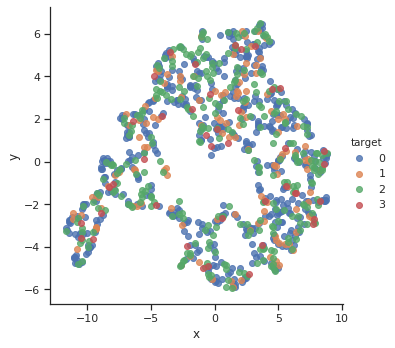

In [0]:
umap = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
new_x = umap.fit_transform(merged_umap_df.iloc[idx,[1,2,3,4,5,6,7]])
postprocess_2d(new_x,merged_umap_df.iloc[idx,[8]].values)

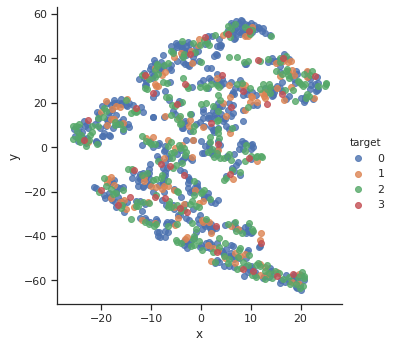

In [0]:
tsne = TSNE(perplexity=30, early_exaggeration=12, learning_rate=200)
new_x = tsne.fit_transform(merged_umap_df.iloc[idx,[1,2,3,4,5,6,7]])
postprocess_2d(new_x,merged_umap_df.iloc[idx,[8]].values)

## Switcher recommender implementation

In [0]:
class MostPopularRecommender():
  def __init__(self):
    pass
  
  def fit(self, X_train):
    assert type(X_train) == pd.DataFrame
    self.most_popular = list(X_train['product_id'].value_counts().index[:])
  
  def predict(self, X_test, top_n):
    #predicted = pd.DataFrame([mp.most_popular[:top_n] for i in range(X_test['user_id'].nunique())])
    predicted = pd.DataFrame()
    predicted['user_id'] = list(X_test['user_id'].unique())
    predicted['product_id'] = [self.most_popular[:top_n] for i in range(X_test['user_id'].nunique())]
    return predicted

In [0]:
class SwitcherRecommender():
  def __init__(self):
    pass
  def fit(self, X_train):
    self.rec_dict = {}
    prior_clustered_grouped_df = X_train.groupby('user_class')
    for cluster_label in X_train['user_class'].unique():
      X_train_cluster = prior_clustered_grouped_df.get_group(cluster_label)
      mp = MostPopularRecommender()
      mp.fit(X_train_cluster)
      self.rec_dict[cluster_label] = mp

  def predict(self, X_test, top_n):
      train_clustered_grouped_df = X_test.groupby('user_class')
      predicted = pd.DataFrame()

      for cluster_label in X_test['user_class'].unique():
        X_test_cluster = train_clustered_grouped_df.get_group(cluster_label)
        mp = self.rec_dict[cluster_label]
        cluster_predict = mp.predict(X_test_cluster, top_n)
        predicted = pd.concat([predicted, cluster_predict])
      
      return predicted


In [0]:
switcher_rec = SwitcherRecommender()
switcher_rec.fit(prior_clustered_df)

In [0]:
predicted = switcher_rec.predict(train_clustered_df, top_n=25)

In [0]:
def eval_results(actual, predicted,k):

  def collect(x):
    return list(x)
  
  ground_truth = actual.groupby('user_id').agg({'product_id':collect}).reset_index()
  return mean_average_precision_at_k(list(predicted['product_id']), list(ground_truth['product_id']), k)

In [0]:
eval_results(train_clustered_df, predicted, 25)

0.03326284522310381

Simple most popular

In [0]:
mp = MostPopularRecommender()
mp.fit(prior_orders_merged_df)
predicted = mp.predict(train_orders_merged_df, top_n=25)

In [0]:
eval_results(train_orders_merged_df, predicted, 25)

0.03325867087536548

In [0]:
for val in switcher_rec.rec_dict.values():
  print(len(set(val.most_popular[:50])&set(mp.most_popular[:50])))

50
48
48
49


## Some code for debug

In [0]:
prior_clustered_grouped_df = prior_clustered_df.groupby('user_class')
train_clustered_grouped_df = train_clustered_df.groupby('user_class')

In [0]:
mp = MostPopularRecommender()
mp.fit(X_train)
predicted = mp.predict(X_test, top_n=5)

In [0]:
predicted.head()

In [0]:
ground_truth = X_test.groupby('user_id').agg({'product_id':collect}).reset_index()

In [0]:
ground_truth.head()

In [0]:
mean_average_precision_at_k(list(predicted['product_id']), list(ground_truth['product_id']), k=5)